In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from keras.datasets import reuters

Using TensorFlow backend.


In [3]:
#(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

#The above line of code does not seem to be working. So I had to do the below code to load the Reuters data.

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_X, train_Y), (test_X, test_Y) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

print(train_X[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [4]:
#Each review (row) is of different size. This data needs to be made uniform. 
# i.e. each reviuew (i.e. row) needs to be onehotencoded to a length of 10,000 (we have decided to have only 10000 features)
import numpy as np
from keras.utils.np_utils import to_categorical

def OneHotEncoding_fn(ReutersData, dimension=10000):
    # 8982 x 10k matrix of zeros
    OneHotEncoded_Data = np.zeros((len(ReutersData), dimension))
    for i, sequence in enumerate(ReutersData):
        #Selectively make indices as 1 based on availability of word in the review.
        OneHotEncoded_Data[i, sequence] = 1.
    return OneHotEncoded_Data

x_train = OneHotEncoding_fn(train_X)
x_test = OneHotEncoding_fn(test_X)

y_train = to_categorical(train_Y)
y_test = to_categorical(test_Y)


In [5]:
#create the layers
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import Activation

model = models.Sequential()

#I/P Layer
model.add(layers.Dropout(0.67, input_shape=(10000,)))
model.add(layers.Dense(128, kernel_initializer='he_uniform'))
model.add(layers.ReLU())


#1st hidden layer
model.add(layers.Dropout(0.67))
model.add(layers.Dense(128, kernel_initializer='he_uniform'))
model.add(layers.ReLU())

#model.add(layers.Dropout(0.4))
model.add(layers.Dense(46, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
from keras import optimizers
from keras import losses
from keras import metrics

X_validation = x_train[:800]
X_train_without_val = x_train[800:]
y_validation = y_train[:800]
y_train_without_val = y_train[800:]

#model.compile(optimizer=optimizers.RMSprop(lr=0.001, rho=0.9),
#model.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False),  #Momentum
#model.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True),   #Nesterov
#model.compile(optimizer=optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0),              #Adagrad
model.compile(optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), #Adam
             loss=losses.categorical_crossentropy,
             metrics=[metrics.categorical_accuracy])
                           
history = model.fit(X_train_without_val,
                    y_train_without_val,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_validation,y_validation))


Instructions for updating:
Use tf.cast instead.
Train on 8182 samples, validate on 800 samples
Epoch 1/30
8182/8182 [==============================] - 7s 872us/step - loss: 3.2113 - categorical_accuracy: 0.3123 - val_loss: 2.2954 - val_categorical_accuracy: 0.5412
Epoch 2/30
8182/8182 [==============================] - 4s 489us/step - loss: 2.1695 - categorical_accuracy: 0.5061 - val_loss: 1.6835 - val_categorical_accuracy: 0.6200
Epoch 3/30
8182/8182 [==============================] - 4s 478us/step - loss: 1.8022 - categorical_accuracy: 0.5698 - val_loss: 1.4929 - val_categorical_accuracy: 0.6625
Epoch 4/30
8182/8182 [==============================] - 4s 442us/step - loss: 1.6703 - categorical_accuracy: 0.6127 - val_loss: 1.3831 - val_categorical_accuracy: 0.6850
Epoch 5/30
8182/8182 [==============================] - 4s 444us/step - loss: 1.5446 - categorical_accuracy: 0.6402 - val_loss: 1.2794 - val_categorical_accuracy: 0.7100
Epoch 6/30
8182/8182 [==============================] -

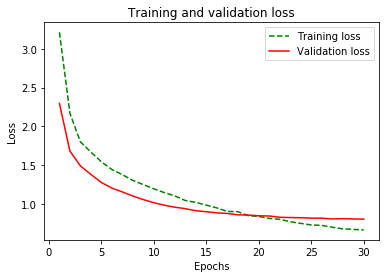

In [10]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'g--', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


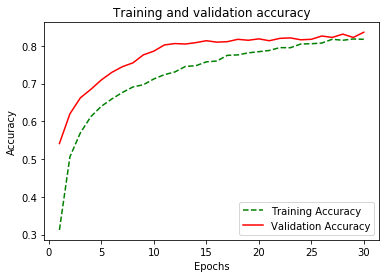

In [8]:
plt.clf()
acc_values = history_dict['categorical_accuracy']
val_acc_values = history_dict['val_categorical_accuracy']
plt.plot(epochs, acc_values, 'g--', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
#Predict the output on the test data.
# A 2D array comprising of 46 probability values (i.e. cols) for each test instance (i.e. rows).
prediction_prob = model.predict(x_test)
#List of the predicted y for all the instances in the test data
pred_y = [np.argmax(prediction_prob[i]) for i in range(prediction_prob.shape[0])]

from sklearn.metrics import accuracy_score
print ('Accuracy Score :', accuracy_score(test_Y, pred_y))

Accuracy Score : 0.8076580587711487
